In [1]:
import warnings

warnings.filterwarnings("ignore")
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

%matplotlib inline

In [2]:
path = ''
data = pd.read_csv(path + 'prices_extract.csv', index_col=["Date_full"], parse_dates=["Date_full"])[['Prix_spot']]

In [3]:
from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Initialize plotly
init_notebook_mode(connected=True)

In [4]:
def plotly_df(df, title=""):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode="lines")
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [5]:
plotly_df(data, title="Daily Price Spot")

In [6]:
weekly_df = data.resample("W").apply(sum)

In [7]:
plotly_df(weekly_df, title="Weekly Price Spot")

In [8]:
daily_df = data.loc[data.index >= "2021-01-01"]
daily_df.head(n=3)

Prix_spot
Date_full                     
2021-01-01 00:00:00      48.19
2021-01-01 00:30:00      48.19
2021-01-01 01:00:00      44.68

In [9]:
import logging

from prophet import Prophet

logging.getLogger().setLevel(logging.ERROR)

In [10]:
df = daily_df
df

Prix_spot
Date_full                     
2021-01-01 00:00:00      48.19
2021-01-01 00:30:00      48.19
2021-01-01 01:00:00      44.68
2021-01-01 01:30:00      44.68
2021-01-01 02:00:00      42.92
...                        ...
2022-11-25 12:30:00     273.55
2022-11-25 13:00:00     290.12
2022-11-25 13:30:00     290.12
2022-11-25 14:00:00     310.42
2022-11-25 14:30:00     310.42

[33192 rows x 1 columns]

In [11]:
df

Prix_spot
Date_full                     
2021-01-01 00:00:00      48.19
2021-01-01 00:30:00      48.19
2021-01-01 01:00:00      44.68
2021-01-01 01:30:00      44.68
2021-01-01 02:00:00      42.92
...                        ...
2022-11-25 12:30:00     273.55
2022-11-25 13:00:00     290.12
2022-11-25 13:30:00     290.12
2022-11-25 14:00:00     310.42
2022-11-25 14:30:00     310.42

[33192 rows x 1 columns]

In [12]:
df = daily_df.reset_index()
df.columns = ["ds", "y"]
# converting timezones (issue https://github.com/facebook/prophet/issues/831)
df["ds"] = df["ds"].dt.tz_localize('UTC').dt.tz_convert('US/Eastern').dt.tz_localize(None)
df.tail(n=3)

ds       y
33189 2022-11-25 08:30:00  290.12
33190 2022-11-25 09:00:00  310.42
33191 2022-11-25 09:30:00  310.42

In [13]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

ds       y
33159 2022-11-24 17:30:00  190.96
33160 2022-11-24 18:00:00  187.67
33161 2022-11-24 18:30:00  187.67

In [14]:
m = Prophet()
m.fit(train_df);


12:52:16 - cmdstanpy - INFO - Chain [1] start processing
12:52:58 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

ds
33185 2022-12-22 18:30:00
33186 2022-12-23 18:30:00
33187 2022-12-24 18:30:00

In [16]:
forecast = m.predict(future)
forecast.tail(n=3)

ds      trend  yhat_lower  yhat_upper  trend_lower  \
33185 2022-12-22 18:30:00  82.797974  -37.500635  207.026667    33.257569   
33186 2022-12-23 18:30:00  80.294072  -50.050356  180.592597    27.061560   
33187 2022-12-24 18:30:00  77.790169  -97.638654  146.383736    20.819104   

       trend_upper  additive_terms  additive_terms_lower  \
33185   140.871677        2.222883              2.222883   
33186   141.905278      -11.411415            -11.411415   
33187   143.267441      -54.185593            -54.185593   

       additive_terms_upper      daily  daily_lower  daily_upper     weekly  \
33185              2.222883 -11.051953   -11.051953   -11.051953  13.274836   
33186            -11.411415 -11.051953   -11.051953   -11.051953  -0.359462   
33187            -54.185593 -11.051953   -11.051953   -11.051953 -43.133640   

       weekly_lower  weekly_upper  multiplicative_terms  \
33185     13.274836     13.274836                   0.0   
33186     -0.359462     -0.359462                   0.0   
33187    -43.133640    -43.133640                   0.0   

       multiplicative_terms_lower  multiplicative_terms_upper       yhat  
33185                         0.0                         0.0  85.020857  
33186                         0.0                         0.0  68.882657  
33187                         0.0                         0.0  23.604577

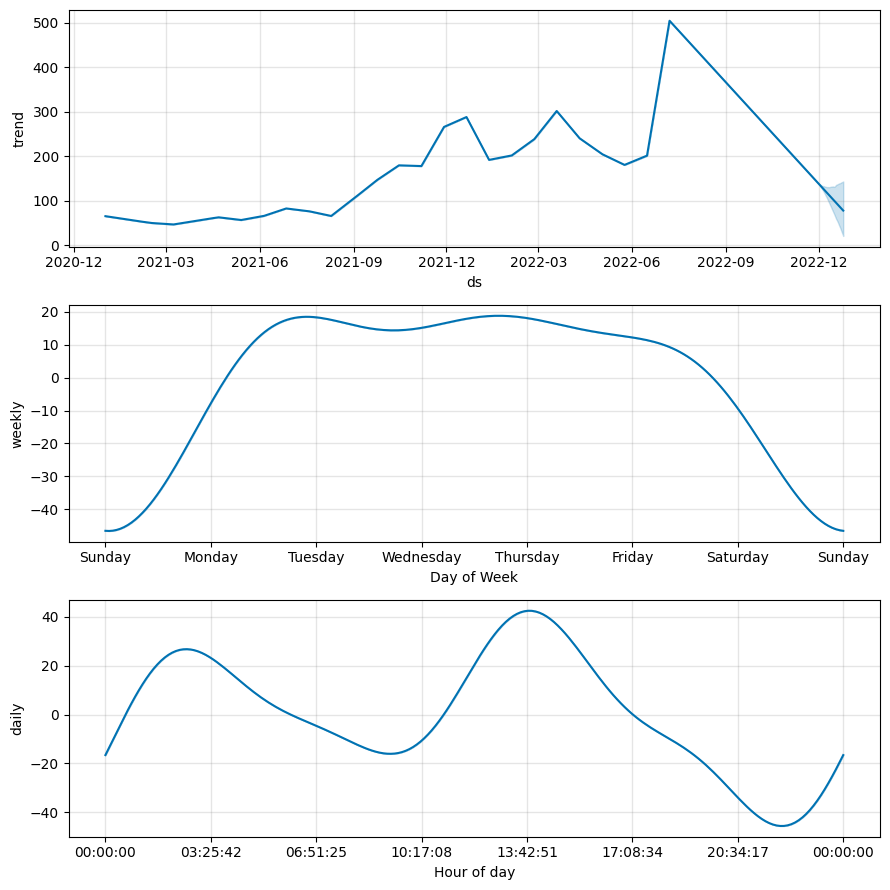

In [17]:
m.plot_components(forecast);

In [18]:
print(", ".join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, daily, daily_lower, daily_upper, weekly, weekly_lower, weekly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [19]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
        historical.set_index("ds")
    )

In [20]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

yhat  yhat_lower  yhat_upper   y
ds                                                        
2022-12-22 18:30:00  85.020857  -37.500635  207.026667 NaN
2022-12-23 18:30:00  68.882657  -50.050356  180.592597 NaN
2022-12-24 18:30:00  23.604577  -97.638654  146.383736 NaN

In [21]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """

    # Make a copy
    df = df.copy()

    # Now we calculate the values of e_i and p_i.
    df["e"] = df["y"] - df["yhat"]
    df["p"] = 100 * df["e"] / df["y"]

    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model.

    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]

    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {"MAPE": error_mean("p"), "MAE": error_mean("e")}

In [22]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE nan
MAE nan


In [23]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""

    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode="lines")
        args.update(kwargs)
        return go.Scatter(**args)

    lower_bound = create_go(
        "Lower Bound",
        "yhat_lower",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
    )
    upper_bound = create_go(
        "Upper Bound",
        "yhat_upper",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
        fillcolor="rgba(68, 68, 68, 0.3)",
        fill="tonexty",
    )
    forecast = create_go(
        "Forecast", "yhat", num_predictions, line=dict(color="rgb(31, 119, 180)")
    )
    actual = create_go("Actual", "y", num_values, marker=dict(color="red"))

    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title="Posts"), title=title, showlegend=False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)


show_forecast(cmp_df, prediction_size, 100, "Prix spot")

In [24]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [25]:
train_df2 = train_df.copy().set_index("ds")

In [26]:
train_df2["y"].to_numpy().reshape(-1, 1).shape

(33162, 1)

In [27]:
train_df2["y"].to_numpy().reshape(-1, 1).ndim

2

In [28]:
train_df2["y"].to_numpy().flatten().ndim

1

In [29]:
data_array = train_df2["y"].to_numpy().flatten()
np.array([train_df2["y"].values]).ndim

2

In [30]:
data_array

array([ 48.19,  48.19,  44.68, ..., 190.96, 187.67, 187.67])

In [31]:
data_array2 = train_df2["y"].to_numpy().reshape(-1, 1)

In [32]:
arr = min_max_scaler.fit_transform(data_array.ravel().reshape(1, -1))

NameError: name 'min_max_scaler' is not defined

In [34]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

train_df2["y"], lambda_prophet = stats.boxcox(min_max_scaler.fit_transform(data_array.ravel().reshape(-1, 1)) )
train_df2.reset_index(inplace=True)

ValueError: Data must be 1-dimensional.